## Clustering speeches on the basis of topics

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


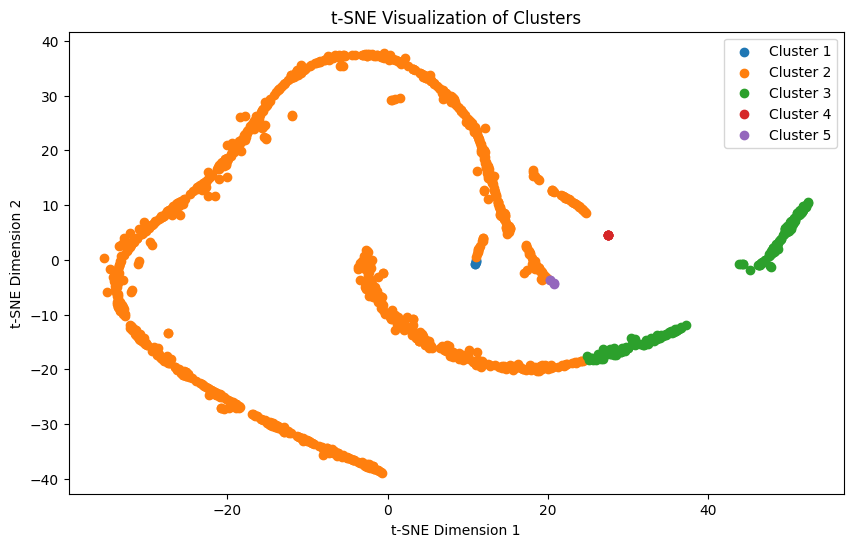

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

speeches_df = pd.read_csv('database.csv')

speeches_df['clean_text'] = speeches_df['Speech'].apply(preprocess_text)

# Feature extraction - TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(speeches_df['clean_text'])

# Topic modeling - Latent Dirichlet Allocation
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda_model.fit_transform(tfidf_features)

# Clustering - K-Means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(lda_topics)

labels = lda_topics.argmax(axis=1)

# t-SNE to visualize the clusters
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(lda_topics)

# Plotting the clusters
plt.figure(figsize=(10, 6))
for i in range(len(set(labels))):
    plt.scatter(tsne_representation[labels == i, 0], tsne_representation[labels == i, 1], label=f'Cluster {i+1}')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

## Top terms in each topic or cluster obtained from K-Means

In [10]:
# Get the top terms for each topic from the LDA model
def get_top_terms(lda_model, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    top_terms = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_terms_idx = topic.argsort()[:-n_terms - 1:-1]
        top_terms.append([terms[i] for i in top_terms_idx])
    return top_terms

# Display the top terms for each topic
top_terms = get_top_terms(lda_model, tfidf_vectorizer)
for i, terms in enumerate(top_terms):
    print(f"Cluster {i+1}: {' '.join(terms)}")

Cluster 1: statement laid regarding forums proceedings creditors gaya contracts leprosy daltonganj
Cluster 2: government country people farmers crore india like minister hon state
Cluster 3: budget government rs court crore courts minister request country family
Cluster 4: statement laid regarding polluted pollution eighth ring need schedule language
Cluster 5: doping weapons antidoping destruction mass financing dna nada nuclear athletes


We can conclude that majority of speeches talks about "government country people farmers crore india like minister hon state"

In [11]:
from collections import Counter

# Compute the distribution of speeches in each cluster
cluster_distribution = Counter(labels)

# Print the distribution
print("Cluster Distribution:")
for cluster, count in cluster_distribution.items():
    print(f"Cluster {cluster + 1}: {count} speeches")

Cluster Distribution:
Cluster 2: 1013 speeches
Cluster 3: 160 speeches
Cluster 4: 6 speeches
Cluster 1: 5 speeches
Cluster 5: 4 speeches


Majority of speeches lies in cluster 2 linked to farmers followed by cluster 3 which is based on budget.

## Yearly distribution of the Speeches in each cluster

To analyze the trend in parliamentary discussions over the years for each topic, showcasing the varying degrees of emphasis placed on each topic annually.

In [12]:
from collections import defaultdict

yearly_speech_distribution = defaultdict(lambda: defaultdict(int))

speeches = speeches_df['Speech']
dates = speeches_df['Date']

for speech, date, cluster_label in zip(speeches, dates, labels):
    year = date.split(", ")[-1]
    yearly_speech_distribution[cluster_label][year] += 1

# Yearly distribution for each cluster
for cluster_label, year_counts in yearly_speech_distribution.items():
    print(f"Cluster {cluster_label + 1}:")
    for year, count in sorted(year_counts.items()):
        print(f"  Year {year}: {count} speeches")
    print()


Cluster 2:
  Year 2019: 458 speeches
  Year 2020: 1 speeches
  Year 2021: 178 speeches
  Year 2022: 223 speeches
  Year 2024: 153 speeches

Cluster 3:
  Year 2019: 49 speeches
  Year 2021: 15 speeches
  Year 2022: 66 speeches
  Year 2024: 30 speeches

Cluster 4:
  Year 2022: 1 speeches
  Year 2024: 5 speeches

Cluster 1:
  Year 2024: 5 speeches

Cluster 5:
  Year 2022: 2 speeches
  Year 2024: 2 speeches



Farmer related talk was a major talked about topic in the year of 2019 which eventually decreased over the span of 5 years. Whereas, we observe the discussion on the budget increased by 34% in year 2022 compared to year 2019.

## Visual Representation

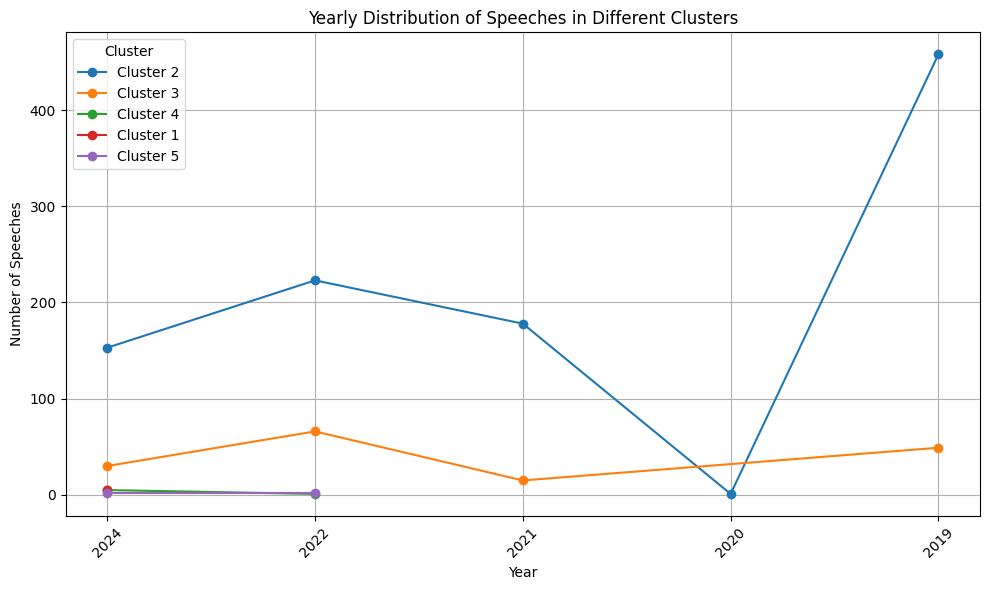

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for cluster_label, year_counts in yearly_speech_distribution.items():
    years = list(year_counts.keys())
    counts = list(year_counts.values())
    plt.plot(years, counts, label=f'Cluster {cluster_label + 1}', marker='o')

plt.title('Yearly Distribution of Speeches in Different Clusters')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.legend(title='Cluster')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()